In [20]:
!pip install seaborn scikit-learn joblib matplotlib pandas


In [21]:
import os
folders = [
    "data",
    "data/outputs",
    "data/outputs/model_rf",
    "data/outputs/anomaly_reports",
    "data/outputs/visuals",
    "models"
]

for f in folders:
    os.makedirs(f, exist_ok=True)

print("✔ Folder structure ready")


✔ Folder structure ready


In [23]:
import pandas as pd
from sklearn.model_selection import train_test_split

INPUT_FILE = "/content/data/failure_patterns_labeled_human.csv"
OUTPUT_DIR = "data"

df = pd.read_csv(INPUT_FILE)
df.columns = df.columns.str.strip().str.lower()



In [24]:

if 'status' in df.columns:
    df['label'] = df['status'].astype(str).str.upper()
elif 'root_cause_label' in df.columns:
    df['label'] = df['root_cause_label']
else:
    raise KeyError("No 'status' or 'root_cause_label' found to create labels.")

meta_cols = [
    'filename', 'dut', 'dut_version', 'os_version', 'config', 'test_case_id',
    'suite', 'run_date', 'execution_duration', 'failure_freq_suite',
    'failure_freq_dut', 'recent_failure_flag'
]
meta_cols = [c for c in meta_cols if c in df.columns]

feature_cols = ['error_msg', 'cluster', 'root_cause_label', 'keywords']
feature_cols = [c for c in feature_cols if c in df.columns]



In [25]:
df = df[meta_cols + feature_cols + ['label']]
df.fillna({'cluster': -1, 'root_cause_label': 'Normal'}, inplace=True)
df.fillna("Unknown", inplace=True)

train_df, test_df = train_test_split(
    df, test_size=0.2, random_state=42, stratify=df['label']
)

train_df.to_csv("data/train_dataset.csv", index=False)
test_df.to_csv("data/test_dataset.csv", index=False)

print("✔ Data preparation completed!")


✔ Data preparation completed!


In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report



In [28]:
TRAIN_FILE = "/content/data/train_dataset.csv"
TEST_FILE = "/content/data/test_dataset.csv"
OUTPUT_DIR = "data/outputs/model_rf"
MODEL_DIR = "models"

train_df = pd.read_csv(TRAIN_FILE)
test_df = pd.read_csv(TEST_FILE)

X_train = train_df["error_msg"].astype(str)
y_train = train_df["label"].astype(str)

X_test = test_df["error_msg"].astype(str)
y_test = test_df["label"].astype(str)



In [29]:
vectorizer = TfidfVectorizer(max_features=5000, stop_words="english", ngram_range=(1,2))
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

rf = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)
rf.fit(X_train_vec, y_train)

y_pred = rf.predict(X_test_vec)
y_prob = rf.predict_proba(X_test_vec).max(axis=1)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1-score:", f1_score(y_test, y_pred, average="weighted"))



Accuracy: 0.9814061592097618
F1-score: 0.9813958050150176


In [30]:
# Save classification report
report = classification_report(y_test, y_pred, output_dict=True)
pd.DataFrame(report).transpose().to_csv(f"{OUTPUT_DIR}/classification_report.csv")




In [31]:
# Confusion matrix
plt.figure(figsize=(6,5))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Random Forest")
plt.savefig(f"{OUTPUT_DIR}/confusion_matrix.png")
plt.close()

# Save predictions
classified_df = pd.DataFrame({
    "TestCase": test_df.get("test_case_id", "N/A"),
    "DUT": test_df.get("dut", "N/A"),
    "Suite": test_df.get("suite", "N/A"),
    "PredictedLabel": y_pred,
    "ActualStatus": y_test,
    "Confidence": y_prob,
    "ErrorMsg": X_test
})

classified_df.to_csv(f"{OUTPUT_DIR}/classified_logs.csv", index=False)

joblib.dump(rf, f"{MODEL_DIR}/rf_model.pkl")
joblib.dump(vectorizer, f"{MODEL_DIR}/tfidf_vectorizer.pkl")

print("✔ Classification completed")

✔ Classification completed


In [32]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack
import matplotlib.pyplot as plt
import seaborn as sns
import joblib



In [39]:
INPUT_FILE = "/content/data/failure_patterns_labeled_human.csv"
OUTPUT_DIR = "data/outputs/anomaly_reports"
MODEL_DIR = "models"

df = pd.read_csv(INPUT_FILE)

TEXT_COL = "error_msg"
NUMERIC_FEATURES = [
    "execution_duration",
    "failure_freq_suite",
    "failure_freq_dut",
    "time_since_last_failure"
]
num_cols = [c for c in NUMERIC_FEATURES if c in df.columns]

vectorizer = TfidfVectorizer(max_features=2000, stop_words="english")
X_text = vectorizer.fit_transform(df[TEXT_COL].astype(str))

scaler = StandardScaler()
X_num = scaler.fit_transform(df[num_cols].fillna(0))

X = hstack([X_text, X_num])

iso = IsolationForest(contamination=0.05, n_estimators=300, random_state=42)
iso.fit(X)




IsolationForest(contamination=0.05, n_estimators=300, random_state=42)

In [40]:
df["anomaly_score"] = iso.decision_function(X)
threshold = np.percentile(df["anomaly_score"], 5)
df["is_anomaly"] = (df["anomaly_score"] < threshold).astype(int)

df["LogID"] = df.index + 1
df["MessageSnippet"] = df[TEXT_COL].str[:150]

df.to_csv(f"{OUTPUT_DIR}/anomaly_full_scores.csv", index=False)
df[df["is_anomaly"] == 1][["LogID", "MessageSnippet", "anomaly_score", "is_anomaly"]].to_csv(
    f"{OUTPUT_DIR}/anomalies_detected.csv", index=False
)

joblib.dump(iso, f"{MODEL_DIR}/isolation_forest.pkl")
joblib.dump(vectorizer, f"{MODEL_DIR}/tfidf_anomaly.pkl")
joblib.dump(scaler, f"{MODEL_DIR}/scaler_anomaly.pkl")

print("✔ Anomaly detection complete")

✔ Anomaly detection complete


In [42]:

from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer

CLASSIFIED = "data/outputs/model_rf/classified_logs.csv"
ANOMALY = "data/outputs/anomaly_reports/anomaly_full_scores.csv"
OUTPUT_DIR = "data/outputs/visuals"

df_class = pd.read_csv(CLASSIFIED)
df_anom = pd.read_csv(ANOMALY)



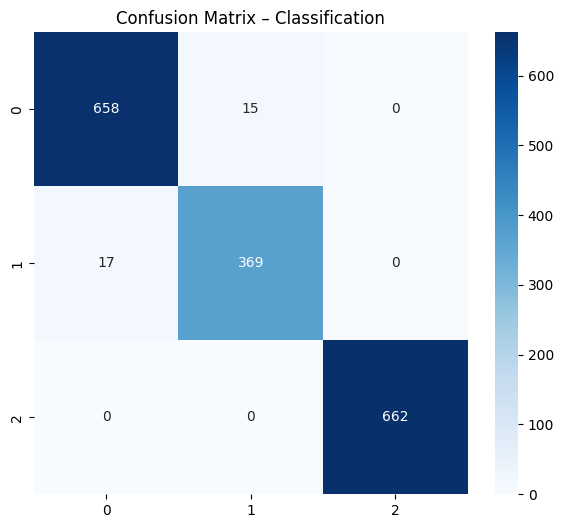

In [44]:
# Confusion Matrix (already saved)
cm = confusion_matrix(df_class["ActualStatus"], df_class["PredictedLabel"])
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix – Classification")
plt.savefig(f"{OUTPUT_DIR}/confusion_matrix.png")
plt.show()
plt.close()



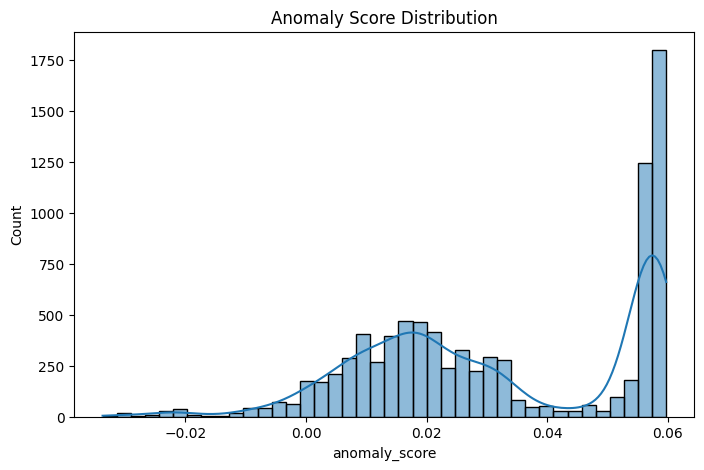

In [45]:
# Anomaly score histogram
plt.figure(figsize=(8,5))
sns.histplot(df_anom["anomaly_score"], bins=40, kde=True)
plt.title("Anomaly Score Distribution")
plt.savefig(f"{OUTPUT_DIR}/anomaly_score_histogram.png")
plt.show()
plt.close()



In [46]:
# TF-IDF → PCA/TSNE visualization
vectorizer = TfidfVectorizer(max_features=300, stop_words="english")
X = vectorizer.fit_transform(df_anom["MessageSnippet"].fillna("")).toarray()




In [47]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
pca_data = pca.fit_transform(X_scaled)
df_anom["pca1"], df_anom["pca2"] = pca_data[:,0], pca_data[:,1]



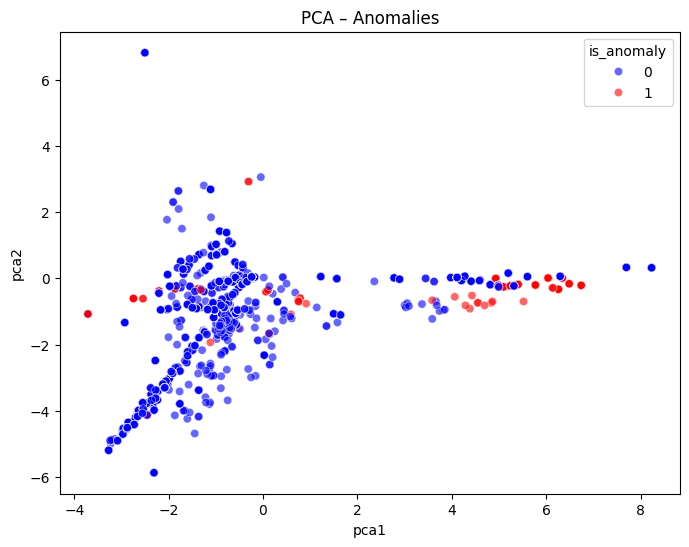

✔ Visualization completed


In [48]:
plt.figure(figsize=(8,6))
sns.scatterplot(x="pca1", y="pca2", hue="is_anomaly", data=df_anom,
                palette={0:"blue",1:"red"}, alpha=0.6)
plt.title("PCA – Anomalies")
plt.savefig(f"{OUTPUT_DIR}/pca_scatter.png")
plt.show()
plt.close()



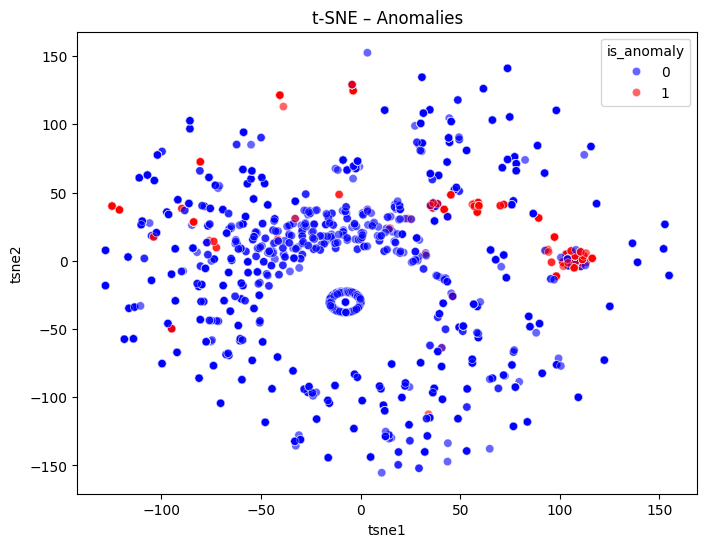

✔ Visualization completed


In [49]:
# t-SNE
tsne = TSNE(n_components=2, perplexity=35, learning_rate=200)
tsne_data = tsne.fit_transform(X_scaled)

df_anom["tsne1"], df_anom["tsne2"] = tsne_data[:,0], tsne_data[:,1]

plt.figure(figsize=(8,6))
sns.scatterplot(x="tsne1", y="tsne2", hue="is_anomaly", data=df_anom,
                palette={0:"blue",1:"red"}, alpha=0.6)
plt.title("t-SNE – Anomalies")
plt.savefig(f"{OUTPUT_DIR}/tsne_scatter.png")
plt.show()
plt.close()

print("✔ Visualization completed")